# Exploratory analysis of graph

This notebook contains a function to explore the graph we created.

In [105]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from scipy.spatial.distance import pdist, squareform
import scipy

import networkx as nx
from networkx.algorithms.community import greedy_modularity_communities

DATA_PATH = '../data/ml-100k-convert/'
GENERATED_PATH = '../generated/'
RESULT_PATH = '../results/'

In [106]:
from sklearn.cluster import KMeans
def compute_laplacian(adjacency: np.ndarray, normalize: bool):
    """ Return:
        L (n x n ndarray): combinatorial or symmetric normalized Laplacian.
    """
    diags = np.diag(np.sum(adjacency,axis=0))
    if not(normalize):
        return diags - adjacency
    else:
        with np.errstate(divide='ignore'):
            diags_sqrt = 1.0/np.sqrt(diags)
        diags_sqrt[np.isinf(diags_sqrt)] = 0
        
        return np.identity(adjacency.shape[0]) - diags_sqrt.dot(adjacency).dot(diags_sqrt)
    
# the return np.linalg.eig(laplacian) seemed to give an error (eigenvalues normalized above 1)
def spectral_decomposition(laplacian: np.ndarray):
    """ Return:
        lamb (np.array): eigenvalues of the Laplacian
        U (np.ndarray): corresponding eigenvectors.
    """
    #return np.linalg.eig(laplacian)
    lamb, U = np.linalg.eigh(laplacian)
    return lamb , U

def plot_eigenvalues(adjacency):
    laplacian = compute_laplacian(adjacency, normalize = True)
    lam, U = spectral_decomposition(laplacian)
    limit = 0.15
    print (f'{np.count_nonzero(lam < limit)} Eigenvalues below {limit}')
    plot_y = lam[:]
    plt.scatter(range(len(plot_y)), plot_y)
    plt.plot(range(len(plot_y)), [limit] * len(plot_y), 'r-')
    plt.show()
           
class SpectralClustering():
    def __init__(self, n_classes: int, normalize: bool, adjacency = None):
        self.n_classes = n_classes
        self.normalize = normalize
        self.laplacian = None
        self.e = None
        self.U = None
        self.lam = None
        
    def fit_predict(self, adjacency = None):
        """ Your code should be correct both for the combinatorial
            and the symmetric normalized spectral clustering.
            Return:
            y_pred (np.ndarray): cluster assignments.
        """
        self.U = U[:,:self.n_classes]
        if self.normalize:
            t = np.sqrt((self.U**2).sum(axis=1)).reshape(len(adjacency),1)
            self.U /= t
        print(self.n_classes)
        return KMeans(n_clusters = self.n_classes).fit_predict(self.U)
    
def laplacian_eigenmaps(adjacency, dim: int, normalize: bool):
    """ Return:
        coords (n x dim array): new coordinates for the data points."""
    laplacian = compute_laplacian(adjacency, normalize=normalize)
    lamb_all, U_all = spectral_decomposition(laplacian)
    coords = U_all[:,1:dim+1]
    return coords

def moment_1(arr):
    return np.mean(arr)
def moment_2(arr):
    return np.sum(np.power(arr,2)) / arr.shape[0]

In [222]:
def poisson(k, lamb):
    return (lamb**k/scipy.special.factorial(k)) * np.exp(-lamb)

def gaus(x,a,x0,sigma):
    return a*np.exp(-(x-x0)**2/(2*sigma**2))

def graph_exploratory_analysis(graph, graph_type="ratings"):
    # Basic stats
    print('Number of nodes: {}, Number of edges: {}'. format(graph.number_of_nodes(), graph.number_of_edges()))
    # Number of connected components
    print('Number of connected components: {}'. format(nx.number_connected_components(graph)))
    # Diameter
    if nx.number_connected_components(graph) == 1:
        print('Diameter of the graph: {}'.format(nx.diameter(graph)))
    # Clustering coefficient
    print('Clustering coefficient: {}'.format(nx.average_clustering(graph)))
    # Degree distribution 
    degrees = [d for n,d in graph.degree()]
    
    entries, bin_edges, patches = plt.hist(degrees, bins = 11, normed = True)
    bin_middles = 0.5*(bin_edges[1:] + bin_edges[:-1])
    mean = sum(bin_middles * entries) / len(bin_middles)
    sigma = sum(entries*(bin_middles-mean)**2)/ len(bin_middles)
    
    popt,pcov = scipy.optimize.curve_fit(gaus,bin_middles,entries,p0=[1,mean,sigma])
    
   # degrees = np.random.poisson(2, 5000)
#     arr = np.histogram(degrees, bins = 20, normed = True)
#     bin_pos = arr[1][:-1] + np.diff(arr[1]) / 2
#     parameters, cov_matrix = scipy.optimize.curve_fit(poisson, bin_pos, arr[0]) 
    
    parameters, cov_matrix = scipy.optimize.curve_fit(poisson, bin_middles, entries)
    x_plot = np.linspace(np.min(bin_middles),np.max(bin_middles))
    #plt.plot(x_plot,poisson(x_plot, *parameters))
    #plt.plot(x_plot,poisson(x_plot, bin_middles[np.argmax(entries)]))
    plt.plot(x_plot,gaus(x_plot,*popt),'-',c = 'xkcd:gray', label='fit')
    print(parameters)
    
    plt.title("Degree distribution")
    plt.xlabel("Degree")
    plt.ylabel("# of nodes")
    plt.savefig(RESULT_PATH+'movie_'+graph_type+'_graph_degree_distribution.eps')
    plt.show()
    
    plt.loglog(bin_middles, entries,'o')
    #plt.loglog(x_plot,poisson(x_plot, *parameters))
    #plt.loglog(x_plot,poisson(x_plot, bin_middles[np.argmax(entries)]))
    plt.loglog(x_plot,gaus(x_plot,*popt),'g-',label='fit')
    plt.title("Degree distribution Log-Log")
    plt.xlabel("Degree")
    plt.ylabel("# of nodes")
    plt.savefig(RESULT_PATH+'movie_'+graph_type+'_graph_degree_distribution_loglog.eps')
    plt.show()
    
    print(f'mean degree', np.mean(degrees))
    print(f'2nd moment of degrees:', np.sum(np.power(degrees,2)) / len(degrees))
    
    # Centrality
    centrality = list(nx.degree_centrality(graph).values())
    print('Mean degree centrality of nodes: {}'.format(np.mean(centrality)))
    
    # largest connected component
    Gc = max(nx.connected_component_subgraphs(graph), key=len)
    print(f'Diameter of largest connected component: {nx.diameter(Gc)}')
    
    print(f'Average clustering: {nx.average_clustering(graph)}')
      
    print()
    
    print('Eigenvalue distribution of the graph')
    plot_eigenvalues(adjacency)
    
    coords2D = laplacian_eigenmaps(adjacency, 2, normalize = True)
    
    print('Laplacian Eigenmaps of the Graph')
    plt.scatter(coords2D[:, 0], coords2D[:, 1])
    

## Movie Ratings Graph

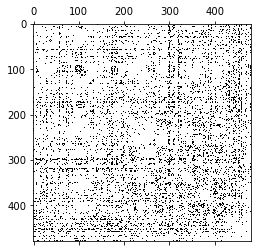

In [223]:
adjacency = np.loadtxt(GENERATED_PATH+'movie_ratings_adj.csv', delimiter=',')
plt.spy(adjacency)
plt.show()

Number of nodes: 480, Number of edges: 14452
Number of connected components: 6
Clustering coefficient: 0.2837056950074333
[3.17830756]


/home/ng/miniconda3/envs/ntds_2019/lib/python3.7/site-packages/ipykernel_launcher.py:20: MatplotlibDeprecationWarning: 
The 'normed' kwarg was deprecated in Matplotlib 2.1 and will be removed in 3.1. Use 'density' instead.
/home/ng/miniconda3/envs/ntds_2019/lib/python3.7/site-packages/ipykernel_launcher.py:2: RuntimeWarning: overflow encountered in power
  
/home/ng/miniconda3/envs/ntds_2019/lib/python3.7/site-packages/ipykernel_launcher.py:2: RuntimeWarning: invalid value encountered in true_divide
  


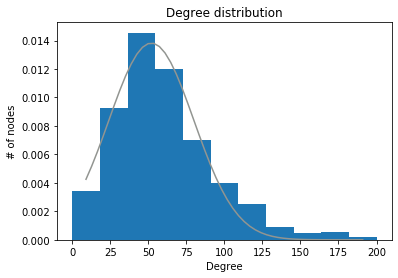

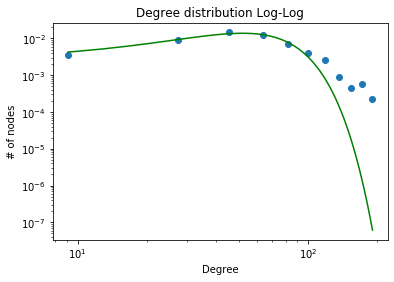

mean degree 60.21666666666667
2nd moment of degrees: 4716.8875
Mean degree centrality of nodes: 0.12571329157967986
Diameter of largest connected component: 4
Average clustering: 0.2837056950074333

Eigenvalue distribution of the graph
1 Eigenvalues bewlow 0.15


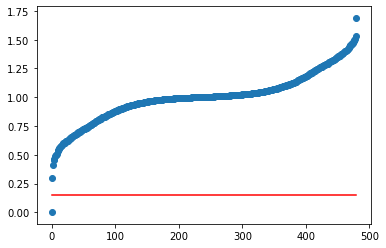

Laplacian Eigenmaps of the Graph


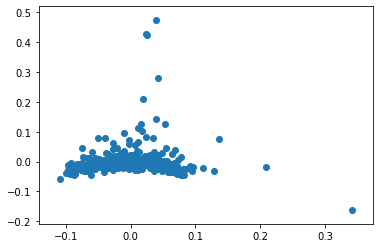

In [224]:
graph = nx.from_numpy_matrix(adjacency)
graph_exploratory_analysis(graph)

## Movie Feature Graph

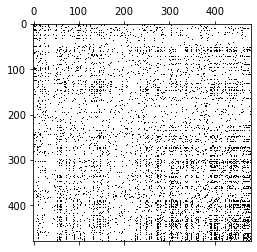

In [225]:
# Lukas load here your movie feature graph
adjacency = np.loadtxt(GENERATED_PATH+'movie_features_adjacency.csv', delimiter=',')
plt.spy(adjacency)
plt.show()

Number of nodes: 480, Number of edges: 12825
Number of connected components: 1
Diameter of the graph: 4
Clustering coefficient: 0.4196046473410347
[2.73384645]


/home/ng/miniconda3/envs/ntds_2019/lib/python3.7/site-packages/ipykernel_launcher.py:20: MatplotlibDeprecationWarning: 
The 'normed' kwarg was deprecated in Matplotlib 2.1 and will be removed in 3.1. Use 'density' instead.


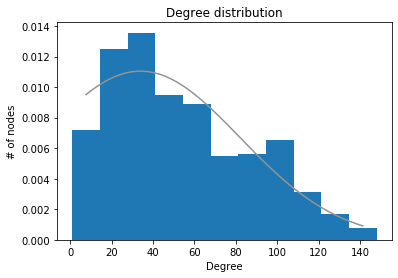

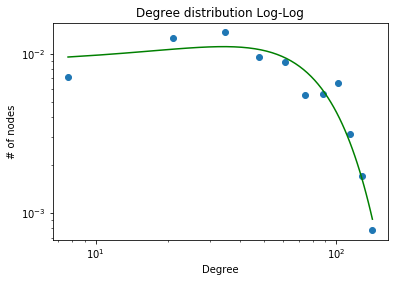

mean degree 53.4375
2nd moment of degrees: 3982.1583333333333
Mean degree centrality of nodes: 0.11156054279749478
Diameter of largest connected component: 4
Average clustering: 0.4196046473410347

Eigenvalue distribution of the graph
1 Eigenvalues bewlow 0.15


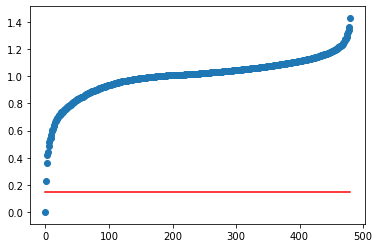

Laplacian Eigenmaps of the Graph


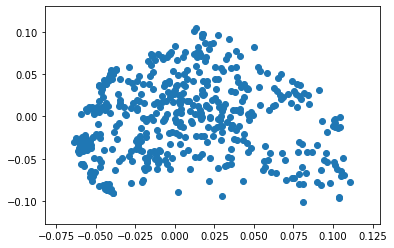

In [226]:
graph = nx.from_numpy_matrix(adjacency)
graph_exploratory_analysis(graph)

## User Graph

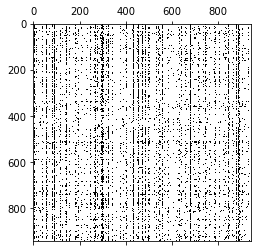

In [227]:
adjacency = np.loadtxt(GENERATED_PATH+'user_ratings_adj.csv', delimiter=',')
plt.spy(adjacency)
plt.show()

Number of nodes: 943, Number of edges: 106640
Number of connected components: 1
Diameter of the graph: 3
Clustering coefficient: 0.5763967938396763
[1.]


/home/ng/miniconda3/envs/ntds_2019/lib/python3.7/site-packages/ipykernel_launcher.py:20: MatplotlibDeprecationWarning: 
The 'normed' kwarg was deprecated in Matplotlib 2.1 and will be removed in 3.1. Use 'density' instead.


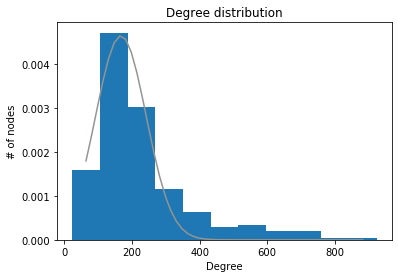

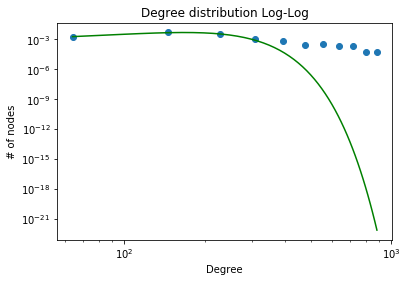

mean degree 226.17179215270414
2nd moment of degrees: 73040.30752916225
Mean degree centrality of nodes: 0.24009744389883667
Diameter of largest connected component: 3
Average clustering: 0.5763967938396763

Eigenvalue distribution of the graph
23 Eigenvalues bewlow 0.15


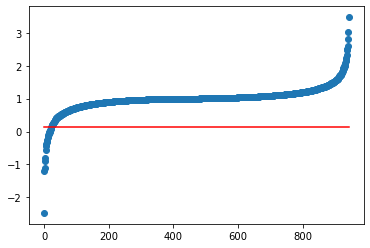

Laplacian Eigenmaps of the Graph


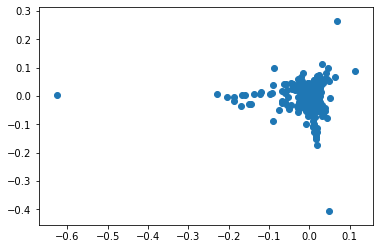

In [228]:
graph = nx.from_numpy_matrix(adjacency)
graph_exploratory_analysis(graph)